# Introduction

Undertaking a supervised classification is not the only way of classifying our imagery. Another commonly used method is to use a rule base. Rule bases take a considerable amount of time and effort to create as you need to define the rules to identify each class uniquely from the others (e.g., split up the feature space). However, as you can directly change the rules they do allow you to more easily change the classification result. 

In this notebook we will undertake a simple pixel level rule based classification using the `band_math` function within the `rsgislib.imagecalc` module.



## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_



# 1. Import relevant modules

In [3]:
import rsgislib
import rsgislib.imagecalc
import rsgislib.imagecalc.calcindices
import rsgislib.rastergis
import rsgislib.tools.plotting

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# 2. Define the input image

In [2]:
# Input Sentinel-2 image file with 20 m resolution pixels.
input_img = "../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif"

# A valid pixel mask for the input image - this is required for later
# steps but note that for this particular image all the pixel values
# are valid (i.e., there aren't are no data regions).
in_msk_img = "../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif"

# 3. Create Useful Indices

It is often useful to create indices such as the NDVI and NDWI etc. and include those within our classification, whether than is a rule based or supervised machined learning classifier. Includes additional layers of relevant information is commonly referred to as *feature engineering*. 


In [4]:
# The output NDVI image file
ndvi_output_img = "sen2_20180629_aber_ndvi.kea"

rsgislib.imagecalc.calcindices.calc_ndvi(
    input_img,
    img_red_band=3,
    img_nir_band=8,
    output_img=ndvi_output_img,
    calc_stats=True,
    gdalformat="KEA",
)

Image: ../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif
	 Variable 'red' is band 3
	 Variable 'nir' is band 8
New image width = 3295 height = 2880 bands = 1



Calculating Image Pyramids.



In [24]:
# The output NDWI image file
ndwi_output_img = "sen2_20180629_aber_ndwi.kea"

rsgislib.imagecalc.calcindices.calc_gmndwi(
    input_img, 
    img_green_band=2, 
    img_swir1_band=9, 
    output_img=ndwi_output_img, 
    calc_stats=True, 
    gdalformat='KEA')

Image: ../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif
	 Variable 'green' is band 2
	 Variable 'swir' is band 9
New image width = 3295 height = 2880 bands = 1



Calculating Image Pyramids.



# 4. Define the `band_math` band definitions

In [32]:
band_defns = list()
band_defns.append(rsgislib.imagecalc.BandDefn("vmsk", in_msk_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("ndvi", ndvi_output_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("ndwi", ndwi_output_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("blue", input_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("green", input_img, 2))
band_defns.append(rsgislib.imagecalc.BandDefn("red", input_img, 3))
band_defns.append(rsgislib.imagecalc.BandDefn("nir", input_img, 8))
band_defns.append(rsgislib.imagecalc.BandDefn("swir1", input_img, 9))

# 5. Create rule base expression

First we need to understand the [if-else expression](https://beltoforion.de/en/muparser/features.php#idDef3) syntax of muparser as this will be how we define our rules:

> `<expression>?<true value>:<false value>`

> `if <expression> then <true value> else <false value>`

When defining a complex expression that this is likely to be it is worth remembering that Python allows a string to be build across multiple lines:

In [18]:
example_str = \
"Hello "\
"World"

print(example_str)

Hello World


## 5.1 How to define rules

This is the difficult bits, which requiring both expert knowledge of the domain and imagery you are using. Even with that expert knowledge is still usually a very time consuming process.

When trying to define the rules for a class you are interested in you need to look at the pixels values and try to define what range of pixel values uniquely defines the class you are interested in. For example, if we want to define a class 'Water' then we would probably look for a threshold in the NDWI indice. Open this image in your image viewer (e.g., Tuiview) and click around on pixel values to estimate what this threshold should be.

Initial lets try a value of `> 0.5`, where the class water will have an output value of 9 to be consistent with the other classification notebooks.



In [27]:
exp = \
"vmsk==0?0:"\
"ndwi>0.5?9:"\
"0"

In [29]:
print(exp)

vmsk==0?0:ndwi>0.5?9:0


## 5.2 Test the Inital Water Classification

In [33]:
init_water_cls_img = "init_water_cls_v1.kea"
rsgislib.imagecalc.band_math(init_water_cls_img, exp, gdalformat="KEA", datatype=rsgislib.TYPE_8UINT, band_defs=band_defns)


Image: ../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif
	 Variable 'blue' is band 1
	 Variable 'green' is band 2
	 Variable 'red' is band 3
	 Variable 'nir' is band 8
	 Variable 'swir1' is band 9
Image: ../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif
	 Variable 'vmsk' is band 1
Image: sen2_20180629_aber_ndvi.kea
	 Variable 'ndvi' is band 1
Image: sen2_20180629_aber_ndwi.kea
	 Variable 'ndwi' is band 1
New image width = 3295 height = 2880 bands = 1



To aid visualisation populate the output image with a colour table and statistics. As it will be a thematic image (i.e., an integer image with discrete image pixel values) and a KEA image use the `rastergis.pop_rat_img_stats` function. 

In [35]:
rsgislib.rastergis.pop_rat_img_stats(init_water_cls_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True)

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



### Visualise Initial Water Classification

You will probably be best opening the result in tuiview to interactively look at the result but below provides an initial look at the result.


Image Data Size: 1250 x 1250
Image Data Size: 1250 x 1250


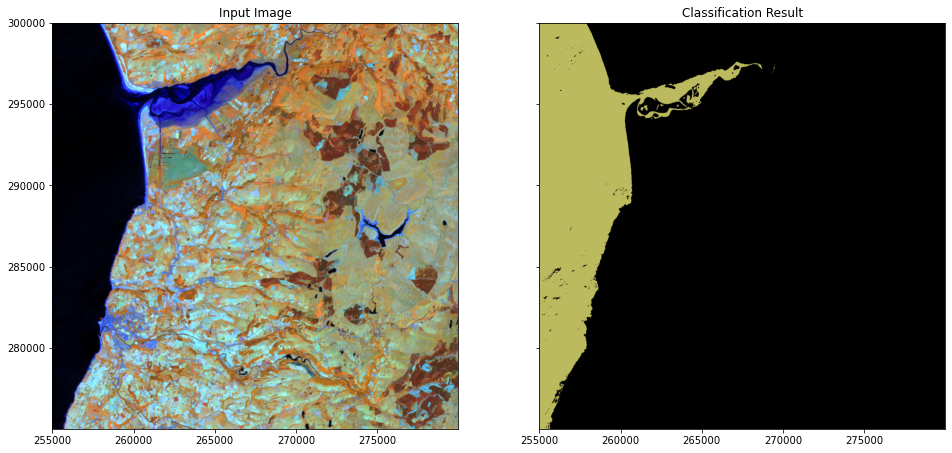

In [40]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [255000, 280000, 275000, 300000]

# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_s2_data, img_s2_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[8, 9, 3], bbox=sub_img_bbox
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_s2_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_s2_data, no_data_val=0.0
)


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_cls_data,
    img_cls_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    init_water_cls_img, out_patches=False, bbox=sub_img_bbox
)


# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_s2_data_strch, extent=img_s2_coords)
ax1.title.set_text("Input Image")
ax2.imshow(img_cls_data, extent=img_cls_coords)
ax2.title.set_text("Classification Result")

I would interpret this result as that is has worked for the sea areas but not for the inland water boadies. Try lowering the threshold, try `ndwi < 0.1`.

## 5.3 Updating Water Classification

In [55]:
exp = \
"vmsk==0?0:"\
"ndwi>0.1?9:"\
"0"

In [56]:
init_water_cls_img = "init_water_cls_v2.kea"
rsgislib.imagecalc.band_math(init_water_cls_img, exp, gdalformat="KEA", datatype=rsgislib.TYPE_8UINT, band_defs=band_defns)
rsgislib.rastergis.pop_rat_img_stats(init_water_cls_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True)


Image: ../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif
	 Variable 'blue' is band 1
	 Variable 'green' is band 2
	 Variable 'red' is band 3
	 Variable 'nir' is band 8
	 Variable 'swir1' is band 9
Image: ../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif
	 Variable 'vmsk' is band 1
Image: sen2_20180629_aber_ndvi.kea
	 Variable 'ndvi' is band 1
Image: sen2_20180629_aber_ndwi.kea
	 Variable 'ndwi' is band 1
New image width = 3295 height = 2880 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Image Data Size: 1250 x 1250
Image Data Size: 1250 x 1250


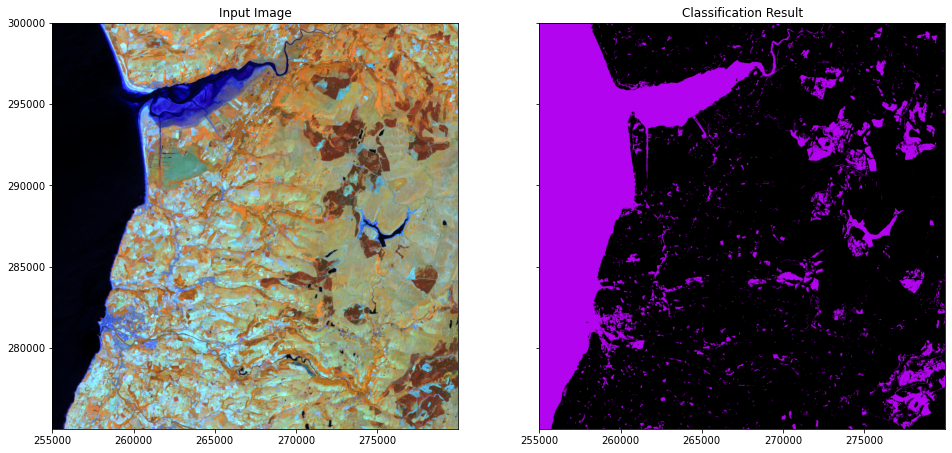

In [57]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [255000, 280000, 275000, 300000]

# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_s2_data, img_s2_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[8, 9, 3], bbox=sub_img_bbox
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_s2_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_s2_data, no_data_val=0.0
)


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_cls_data,
    img_cls_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    init_water_cls_img, out_patches=False, bbox=sub_img_bbox
)


# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_s2_data_strch, extent=img_s2_coords)
ax1.title.set_text("Input Image")
ax2.imshow(img_cls_data, extent=img_cls_coords)
ax2.title.set_text("Classification Result")

This have improved the classification in some areas but maybe the threshold should be lowered further. Try the following thresholds:

 * 0.0
 * -0.1
 * -0.2
 * -0.3
 * -0.4
 * -0.5

What did you observe when you tried these different thresholds? What do you think the optimal threshold is for classifying water while not misclassifying other land covers?

# 6. Including Multiple Classes

## 6.1 Initial Set of Rules

In [59]:
exp = \
"vmsk==0?0:"\
"ndwi>-0.25?9:"\
"(ndwi>-0.45)&&(ndvi>0.2)?3:"\
"(ndwi>-0.5)&&(ndvi<0.2)?1:"\
"0"

In [60]:
init_multi_cls_img = "multi_cls_rslt_v1.kea"
rsgislib.imagecalc.band_math(init_multi_cls_img, exp, gdalformat="KEA", datatype=rsgislib.TYPE_8UINT, band_defs=band_defns)
rsgislib.rastergis.pop_rat_img_stats(init_multi_cls_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True)



Image: ../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif
	 Variable 'blue' is band 1
	 Variable 'green' is band 2
	 Variable 'red' is band 3
	 Variable 'nir' is band 8
	 Variable 'swir1' is band 9
Image: ../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif
	 Variable 'vmsk' is band 1
Image: sen2_20180629_aber_ndvi.kea
	 Variable 'ndvi' is band 1
Image: sen2_20180629_aber_ndwi.kea
	 Variable 'ndwi' is band 1
New image width = 3295 height = 2880 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Image Data Size: 1250 x 1250
Image Data Size: 1250 x 1250


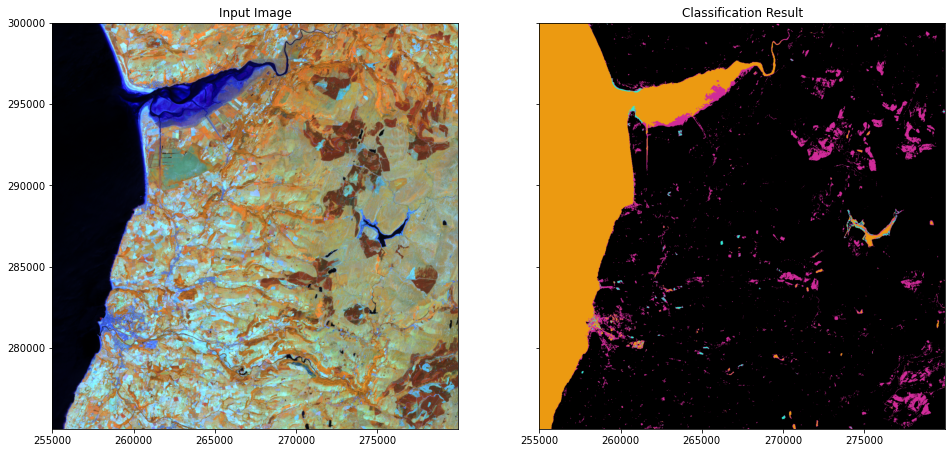

In [61]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [255000, 280000, 275000, 300000]

# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_s2_data, img_s2_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[8, 9, 3], bbox=sub_img_bbox
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_s2_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_s2_data, no_data_val=0.0
)


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_cls_data,
    img_cls_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    init_multi_cls_img, out_patches=False, bbox=sub_img_bbox
)


# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_s2_data_strch, extent=img_s2_coords)
ax1.title.set_text("Input Image")
ax2.imshow(img_cls_data, extent=img_cls_coords)
ax2.title.set_text("Classification Result")

How do you think the inital set of thresholds worked? To me, it looks like there is quite a bit of error. To improve this we need to refine our thresholds... 

Hopefully, what you are getting from this exercise is that working out your thresholds in an iterative process which can very very time consuming. 

## 6.2 Refining the Set of Rules

In [63]:
exp = \
"vmsk==0?0:"\
"ndwi>-0.25?9:"\
"(ndwi>-0.45)&&(ndvi>0.6)?3:"\
"(ndwi>-0.5)&&(ndvi<0.5)?1:"\
"0"

In [64]:
init_multi_cls_img = "multi_cls_rslt_v2.kea"
rsgislib.imagecalc.band_math(init_multi_cls_img, exp, gdalformat="KEA", datatype=rsgislib.TYPE_8UINT, band_defs=band_defns)
rsgislib.rastergis.pop_rat_img_stats(init_multi_cls_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True)



Image: ../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif
	 Variable 'blue' is band 1
	 Variable 'green' is band 2
	 Variable 'red' is band 3
	 Variable 'nir' is band 8
	 Variable 'swir1' is band 9
Image: ../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif
	 Variable 'vmsk' is band 1
Image: sen2_20180629_aber_ndvi.kea
	 Variable 'ndvi' is band 1
Image: sen2_20180629_aber_ndwi.kea
	 Variable 'ndwi' is band 1
New image width = 3295 height = 2880 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Image Data Size: 1250 x 1250
Image Data Size: 1250 x 1250


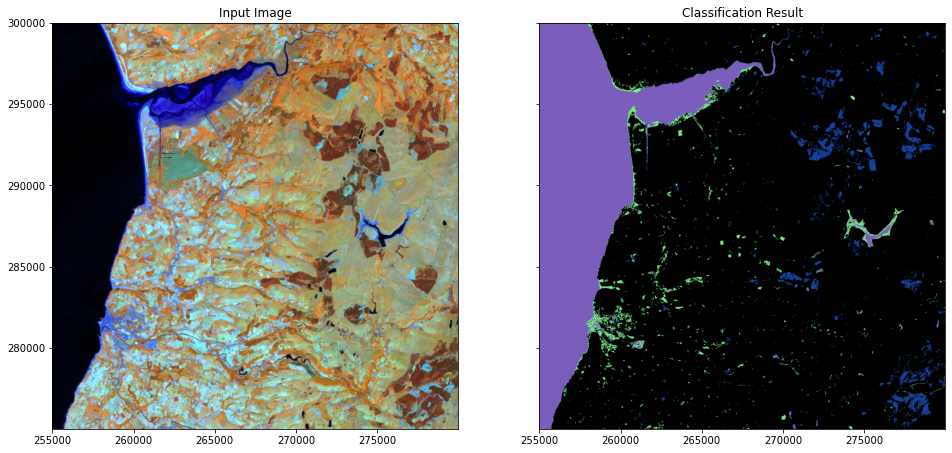

In [65]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [255000, 280000, 275000, 300000]

# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_s2_data, img_s2_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[8, 9, 3], bbox=sub_img_bbox
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_s2_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_s2_data, no_data_val=0.0
)


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_cls_data,
    img_cls_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    init_multi_cls_img, out_patches=False, bbox=sub_img_bbox
)


# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_s2_data_strch, extent=img_s2_coords)
ax1.title.set_text("Input Image")
ax2.imshow(img_cls_data, extent=img_cls_coords)
ax2.title.set_text("Classification Result")

# 7. Define Colours

Probably something you have now found is that having the colour change after each time you change the classification rules is not very helpful. It would be much easier if a consistent colour table was applied to the classification. We can do that using the `rsgislib.rastergis.set_class_names_colours` function.


In [68]:
class_info_dict = dict()
class_info_dict[1] = {'classname': 'Artificial_Surfaces', 'red': 160, 'green': 160, 'blue': 160}
class_info_dict[2] = {'classname': 'Bare_Rock_Sand', 'red': 100, 'green': 100, 'blue': 100}
class_info_dict[3] = {'classname': 'Conifer_Forest', 'red': 2, 'green': 97, 'blue': 16}
class_info_dict[4] = {'classname': 'Deciduous_Forest', 'red': 50, 'green': 184, 'blue': 69}
class_info_dict[5] = {'classname': 'Grass_Long', 'red': 150, 'green': 227, 'blue': 18}
class_info_dict[6] = {'classname': 'Grass_Short', 'red': 194, 'green': 219, 'blue': 66}
class_info_dict[7] = {'classname': 'NonPhoto_Veg', 'red': 98, 'green': 225, 'blue': 227}
class_info_dict[8] = {'classname': 'Scrub', 'red': 0, 'green': 80, 'blue': 0}
class_info_dict[9] = {'classname': 'Water', 'red': 0, 'green': 0, 'blue': 255}
#class_info_dict[10] = {'classname': 'Bracken', 'red': 235, 'green': 146, 'blue': 38}

rsgislib.rastergis.set_class_names_colours(init_multi_cls_img, 'class_names', class_info_dict)

Image Data Size: 1250 x 1250
Image Data Size: 1250 x 1250


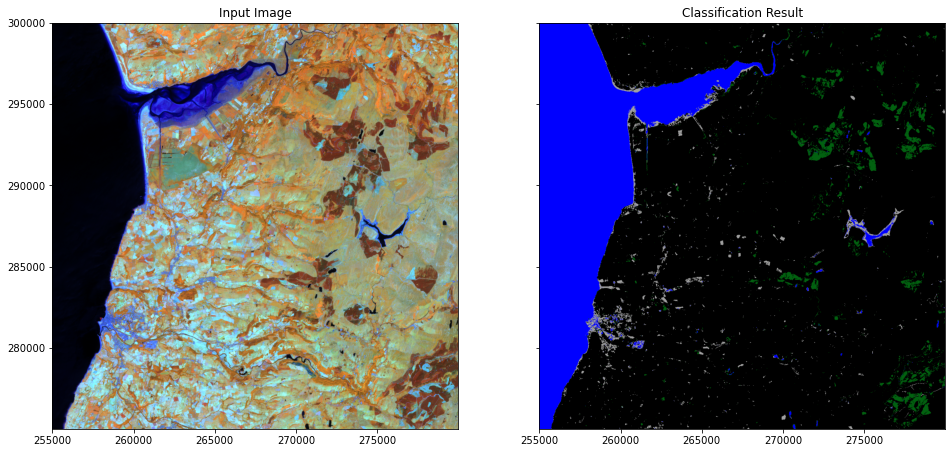

In [69]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [255000, 280000, 275000, 300000]

# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_s2_data, img_s2_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[8, 9, 3], bbox=sub_img_bbox
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_s2_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_s2_data, no_data_val=0.0
)


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_cls_data,
    img_cls_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    init_multi_cls_img, out_patches=False, bbox=sub_img_bbox
)


# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_s2_data_strch, extent=img_s2_coords)
ax1.title.set_text("Input Image")
ax2.imshow(img_cls_data, extent=img_cls_coords)
ax2.title.set_text("Classification Result")

This looks much more consistent and easier to intepret, for next stages you will run `rsgislib.rastergis.set_class_names_colours` after `rsgislib.rastergis.pop_rat_img_stats` to ensure the colours are defined. This function will also as a colour with the class name (called `class_names`) to the attribute table of the image which is also useful for those who are not aware of what pixel value you have used to define each class.

# 8. Improving the Classification 



In [ ]:
exp = \
"vmsk==0?0:"\
"ndwi>-0.25?9:"\
"(ndwi>-0.45)&&(ndvi>0.6)?3:"\
"(ndwi>-0.5)&&(ndvi<0.5)?1:"\
"0"

In [ ]:
init_multi_cls_img = "multi_cls_rslt_v3.kea"
rsgislib.imagecalc.band_math(init_multi_cls_img, exp, gdalformat="KEA", datatype=rsgislib.TYPE_8UINT, band_defs=band_defns)
rsgislib.rastergis.pop_rat_img_stats(init_multi_cls_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True)
rsgislib.rastergis.set_class_names_colours(init_multi_cls_img, 'class_names', class_info_dict)


In [ ]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [255000, 280000, 275000, 300000]

# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_s2_data, img_s2_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[8, 9, 3], bbox=sub_img_bbox
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_s2_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_s2_data, no_data_val=0.0
)


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_cls_data,
    img_cls_coords,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    init_multi_cls_img, out_patches=False, bbox=sub_img_bbox
)


# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_s2_data_strch, extent=img_s2_coords)
ax1.title.set_text("Input Image")
ax2.imshow(img_cls_data, extent=img_cls_coords)
ax2.title.set_text("Classification Result")